In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 5)

In [33]:
assets = pd.read_excel('midterm_2.xlsx', 0, index_col=0)
factors = pd.read_excel('midterm_2.xlsx', 1, index_col=0)
factors.head(2)

,MKT,RMW
Date,,
2009-04-30,0.1018,0.0131
2009-05-31,0.0521,-0.0078


In [34]:
assets.head(2)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.00844,-0.00155,0.15503,0.11464,0.13791,-0.0280,0.2956,0.22965,0.02233,0.09879,-0.01850
2009-05-31,0.05414,0.16313,0.15987,0.13239,0.02903,-0.0203,0.0232,0.05436,0.02834,0.05892,0.02044


# 1 Short Answer

### 1.1 What is done in the construction of the value factor, HML, to reduce its correlation to
- MKT?
- SMB?

Ans:- Given that small cap and value stocks are imperfectly correlated with the overall market, these holdings will reduce risk at the margin for any investor completely invested in funds tracking the broader equity
index. Thus, DFA's proposition to investors is that their funds can diversify a portfolio while adding edge relative to other small-cap and value-stock investments, through their efficient trading and deeper understanding of these factors

### 1.2 The Value factor underperformed in the time since the DFA-case. What might DFA say in defense of value as a good investment, not withstanding these statistics?

Ans:- Inspite of these statistics of low mean excess return the Value factor  as it still provides a good diversification benefit to the portfolio.

### 1.3 We found these tangency portfolio weights for the 4 factor model considered by AQR. What might we conclude from this about this “AQR” pricing model?

Ans:- We might conclude that MKT, HML and UMD are the most important factors in the AQR pricing model, and SMB is the least important factor, as it has the lowest almost negligible weight.

### 1.4 True or False. (And very briefly explain your reasoning.)If the CAPM model worked perfectly, then the MKT factor would have the highest Sharpe ratio and highest Treynor ratio of all assets.

Ans:- False. CAPM states that the expected excess return of a portfolio is proportional to the expected excess return of the market. The Alpha and Information Ratio should be equal to zero. As a consequence, the Treynor Ratio should be equal to mean excess return of the market.

### 1.5 What is the biggest difference in performance between long-only momentum and long- short momentum?

Ans:- The biggest difference in performance between long-only momentum and long- short momentum is that the long only momentum has a higher Sharpe ratio, almost 2x, than the long-short momentum at a comparable level of risk (vols).

### 1.6  We find the following regression results for BTC (bitcoin) returns. Do you think we could operate an effective momentum strategy given just BTC? Explain and be specific.

Ans:- Given a only a single asset would lead to huge level or specific or idisyosyncratic risk. Hence, it is not advisable to operate an effective momentum strategy given just BTC. Moreover, the R-squared is very low, which means that the BTC returns are not predictable.

### 1.7 In the factor model using MKT, SMB, HML, UMD, (the “AQR model”,) which factors can the entire market have a positive net exposure, and which must the market must have net 0 exposure?

Ans:- When conducting the cross sectional regression of the market portfolio on the factors, we find that the HML Cross Sectional premia is negative while the rest of the factors have a positive Cross Sectional premia. This means that the market portfolio has a positive net exposure to the HML factor and a negative net exposure to the rest of the factors.

### 1.8 The APT says that a ”perfect” Linear Factor Decomposition (LFD) will work as a perfect Linear Factor Pricing Model (LFPM). What must the factors achieve as an LFD to meet the APT’s condition?

The factor must achieve below conditions to meet the APT’s condition:
- The set of factors explains realized returns across time. (Covariation)
- The residual is uncorrelated with the factors. (Orthogonality)
- The residuals are uncorrelated with each other. (Independence)

### 1.9 Is it possible for a factor model to fit perfectly as an LFPM yet to fit imperfectly as an LFD?


Yes, it is possible. For instance, the cross section regression of factors leads to a good fit in terms of pricing but the factors do not provide a good R-squared for the time series regression. This means that the factors do not explain the realized returns across time, and hence imperfect as an LFD.

# 2 Pricing Model

### 2.1 Estimate the time-series test of the pricing model.

### 2.1(a)

In [35]:
def ts_test(df, factor_df, factors, constant = True,annualization=12):
    res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha','f_1','f_2', 'r_2', 'treynor', 'info'])
    
    for port in df.columns:
        y = df[port]
        if constant:
            X = sm.add_constant(factor_df[factors])
        else:
            X = factor_df[factors]
        model = sm.OLS(y, X).fit()
        
        if constant:
            beta = model.params[1:]
            alpha = model.params[0] * annualization
            information_ratio = model.params[0] * np.sqrt(annualization) / model.resid.std()
        else:
            beta = model.params
    
        treynor = df[port].mean() * annualization / beta[0]
        tracking_error = model.resid.std() * np.sqrt(annualization)
        if constant:
            res.loc[port] = [alpha, model.params[1], model.params[2], model.rsquared, treynor, information_ratio]
        else:
            res.loc[port] = [None, model.params[0], model.params[1], model.rsquared, treynor, None]
    return res

#df is the asset portfolios which we are regressing
#factor_df is the factor data
#intercept is whether we want to include an intercept in the regression

In [36]:
#Calculate mean, standard deviation and sharpe ratio
def mean_vol_sharpe(df,ann=12):
    mean = df.mean() * ann
    volatility = df.std() * np.sqrt(ann)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

In [37]:
def ts_premia(df_ts, factor_mean):
    #multiply factor premium row wise to each f_1 an f_2 in factor and sum
    premia = pd.DataFrame(data = None, index = df_ts.index, columns = ['TS Premia'])
    for row in df_ts.index:
        a = df_ts.loc[row, 'beta_MKT']* factor_mean[0]
        b = df_ts.loc[row, 'beta_RMW']* factor_mean[1]
        premia.loc[row] = a + b
        
    return premia

In [74]:
CS_reg_performance

,Intercept,f_1,f_2,R-Squared,MAE
Cross-Sectional Regression,-0.02142,0.11865,0.21007,0.90553,0.01094


In [77]:
y = pd.DataFrame(data = assets.mean() * 12, columns = ['mean'])
X = ts_test(assets,factors,['MKT','RMW']).loc[:,['f_1','f_2']]
X = sm.tools.add_constant(X)
X[['f_1','f_2']] = X[['f_1','f_2']].astype(float)
CS_reg_model = sm.OLS(y,X).fit()
CS_reg_performance = CS_reg_model.params.to_frame('Cross-Sectional Regression').T.rename(columns = {'const':'Intercept','Market Beta':'Market Premia','Profitability Beta':'Profitability Premia'})
CS_reg_performance['R-Squared'] = CS_reg_model.rsquared
CS_reg_performance['MAE'] =  abs(CS_reg_model.resid).mean()

CS_asset_premia = np.matrix(ts_test(assets,factors,['MKT','RMW']).loc[:,['f_1','f_2']]) @ np.matrix(CS_reg_performance.loc[:,['f_1','f_2']].T)
CS_asset_premia  = pd.DataFrame(CS_asset_premia, columns = ['Cross-Sectional'], index = assets.columns)
CS_asset_premia

,Cross-Sectional
BWX,0.04954
DBC,0.04757
EEM,0.09204
EFA,0.09421
HYG,0.06137
IEF,0.02586
IYR,0.16574
PSP,0.13601
QAI,0.03361
SPY,0.14068


In [38]:
df_ts = ts_test(assets,factors,['MKT','RMW'])
df_ts.rename(columns={'f_1':'beta_MKT','f_2':'beta_RMW'}, inplace=True)
df_ts

,alpha,beta_MKT,beta_RMW,r_2,treynor,info
BWX,-0.04057,0.2363,0.10237,0.20469,-0.02151,-0.56708
DBC,-0.05202,0.59318,-0.10859,0.25679,0.04584,-0.33285
EEM,-0.06886,0.94362,-0.09481,0.56011,0.06278,-0.53446
EFA,-0.05819,0.93126,-0.07749,0.76222,0.07375,-0.72669
HYG,-0.00039,0.45323,0.03615,0.58864,0.13976,-0.0068
IEF,0.02399,-0.08183,0.16934,0.082,-0.21053,0.41106
IYR,0.00101,0.91336,0.27314,0.55137,0.14765,0.00801
PSP,-0.06593,1.34076,-0.10979,0.83931,0.08709,-0.7301
QAI,-0.02371,0.27825,0.00284,0.71738,0.05356,-0.88525
SPY,0.0006,0.96286,0.12585,0.99235,0.14263,0.04648


In [39]:
### MAE
print('MAE:-',round(df_ts['alpha'].abs().mean(),5))

MAE:- 0.0311


In [40]:
### Mean r-squared
print('Mean r-squared:-',round(df_ts['r_2'].mean(),5))

Mean r-squared:- 0.51551


### 2.1(b) If the pricing model worked perfectly, what would these statistics be?

Ans:- If the pricing model worked perfectly, Regression fit should pass through the market portfolio in case of CAPM. We don’t care about the R-Squared when it comes to pricing,but the alphas should be 0. As a result the MAE would also be 0.

#### 2.1(c) What do you conclude from the time-series test of this model? That is, give some interpretation as to how well it prices the assets, and be specific.

Ans:- The model is not able to price the assets well. The MAE is around 3% which means that there is a component of return which is not being explained by our two factors RWA and MKT. The R-Squared is also very low. As per our knowledge from the case studies, we would expect the UMD and HML to be the extra factors that would benefit the model in terms of fit.

### 2.2. Estimate the cross-sectional test of the pricing model. Include an intercept in the cross-sectional regression.

#### 2.2 (a)

In [114]:
def cross_regression(asset_df, factors_df, factors, intercept=True, annualization=12):
    
    res = pd.DataFrame(data = None, index = factors, columns = ['cs_premia'])
    
    factors_df = factors_df.iloc[:,1:(len(factors)+1)]
    
    y = asset_df.mean() * annualization
    if intercept == True:
        X = sm.add_constant(factors_df[factors].astype(float))
    else:
        X = factors_df[factors].astype(float)
    model = sm.OLS(y, X).fit()
    if intercept:
        alpha = model.params[0]
        mae = model.resid.abs().mean()
        for i in range(len(factors)):
            res.loc[factors[i]] = model.params[i+1]
        predicted_premia = np.matrix(factors_df[factors].astype(float)) @ np.matrix(res.astype(float))
        
    else:
        alpha = None
        mae = model.resid.abs().mean()
        for i in range(len(factors)):
            res.loc[factors[i]] = model.params[i]
        predicted_premia = np.matrix(factors_df[factors].astype(float)) @ np.matrix(res.astype(float))
        
    predicted_premia = pd.DataFrame(predicted_premia, columns = ['Cross-Section Premia'], index = factors_df.index)
    if intercept:
        return predicted_premia,res, f'r-squared = {round(model.rsquared, 4)}', f'alpha = {round(alpha, 4)}', f'mae = {round(mae, 4)}'
    else:
        return predicted_premia,res, f'r-squared = {round(model.rsquared, 4)}', f'mae = {round(mae, 4)}'

In [115]:
factor = ['beta_MKT','beta_RMW']
predicted_premia,cs_premia,r2,alpha,mae = cross_regression(assets,df_ts,factor,intercept=True)


#### annualized intercept.

In [43]:
alpha

'alpha = -0.0214'

#### annualized factor premia.

In [44]:
cs_premia

,cs_premia
beta_MKT,0.11865
beta_RMW,0.21007


#### r-squared.

In [45]:
r2

'r-squared = 0.9055'

#### annualized mean-absolute error.

In [46]:
mae

'mae = 0.0109'

### 2.2(b)If the pricing model worked perfectly, what would these statistics be?

Ans:- If the pricing model worked perfectly, Betas should line up linearly, R-Squared should be 1 and intercepts should be 0. As a result the MAE would also be 0.

### 2.2(c) What do you conclude from the cross-sectional test of this model? That is, give some interpretation as to how well it prices the assets, and be specific.

Ans:- As per the low MAE stats of around 1% and high R_squared of 90% we can say that the model is able to price the assets well. The model is able to explain 90% of the variation in the returns of the assets. Though the alphas are not 0.

## 2.3 Is the RMW factor more lucrative according to the cross-sectional or time-series estimates?

Ans:- Yes, the RMW factor is more lucrative according to the cross-sectional estimates. The RMW factor has a higher premia of 0.21 against 0.11 of MKT.

## 2.4 Make a chart showing the annualized 11 asset premia, (that is, expected excess returns,) as implied by the
- sample average
- LFPM in equation (1) with time-series estimated factor premia
- LFPM in equation (1) with cross-sectional estimated factor premia.1

In [47]:

sample_average = pd.DataFrame(assets.mean() * 12,columns=['sample average'])

#sample_average

In [48]:
factor_mean = mean_vol_sharpe(factors).iloc[:,0]

ts_premia_1 = ts_premia(df_ts, factor_mean)

#ts_premia_1

In [116]:
predicted_premia.rename(columns={'predicted_premia':'cross section premia'}, inplace=True)
#predicted_premia

In [117]:
#combine all premia
premia_all = pd.concat([sample_average, ts_premia_1, predicted_premia], axis=1)
premia_all

,sample average,TS Premia,Cross-Section Premia
BWX,-0.00508,0.03548,0.04954
DBC,0.02719,0.07921,0.04757
EEM,0.05924,0.12811,0.09204
EFA,0.06868,0.12686,0.09421
HYG,0.06334,0.06374,0.06137
IEF,0.01723,-0.00676,0.02586
IYR,0.13486,0.13385,0.16574
PSP,0.11676,0.1827,0.13601
QAI,0.01490,0.03861,0.03361
SPY,0.13733,0.13673,0.14068


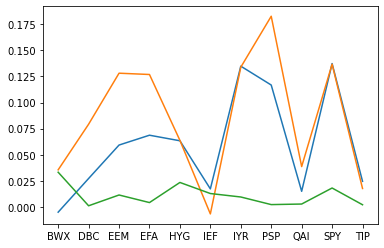

In [51]:
#Make a chart showing the annualized 11 asset premia
plt.plot(premia_all)

# 3 Applications to Previously Seen Topics (15 pts)

### 3.1 Calculate the tangency portfolio of the 11 excess return assets based on sample data. Report the-
- tangency weights
- sharpe ratio of the tangency portfolio

In [52]:
## TANGENCY for Portfolio with excess returns

def compute_tangency(df_tilde, diagonalize_Sigma=False):

    Sigma = df_tilde.cov()

    # N is the number of assets

    N = Sigma.shape[0]

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))

    mu_tilde = df_tilde.mean()

    Sigma_inv = np.linalg.inv(Sigma_adj)

    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    # For convenience, I'll wrap the solution back into a pandas.Series object.
    omega_tangency = pd.Series(weights, index=mu_tilde.index)
    
    return omega_tangency, mu_tilde, Sigma_adj

In [53]:
omega_tangency,_,_ = compute_tangency(assets)
omega_tangency

BWX   -16.68339
DBC     2.66167
EEM     5.00229
EFA    -1.65281
HYG    15.84554
IEF    31.67142
IYR    -4.25101
PSP    -6.98019
QAI   -60.26529
SPY    33.17112
TIP     2.48065
dtype: float64

In [54]:
# Calclulating mean, vol and sharpe ratio of tangency portfolio

def portfolio_stats(df, weights):
    N = df.shape[1]
    mu = df.mean() * 12 #mean
    sig = df.cov() * 12 #covariance
    
    mu_p = weights.T @ mu
    sig_p = np.sqrt(weights.T @ sig @ weights)
    sharpe_p = mu_p/sig_p
    
    print('Mean: ', mu_p, ',\nVol: ', sig_p, ',\nSharpe Ratio: ', sharpe_p)


In [55]:
portfolio_stats(assets, omega_tangency)

Mean:  4.219052147146743 ,
Vol:  2.2913908214976004 ,
Sharpe Ratio:  1.841262567504424


### 3.2 Re-do the previous question regarding the tangency portfolio. But this time, utilize the expected returns as implied by the cross-sectional estimation of the pricing model in the tangency portfolio estimation. That is, use the cross-sectional premia shown in your table from Question 2.4.

In [142]:
N = assets.shape[1]
mu = predicted_premia
sig = assets.cov() * 12 #covariance
sig_inv = np.linalg.inv(sig)
scaling = np.ones(N) @ sig_inv @ mu
om_t = (sig_inv @ mu )/ scaling
om_t.rename(columns={'Cross-Section Premia':'tangency portfolio'}, inplace=True)
om_t.index = assets.columns
om_t

,tangency portfolio
BWX,0.33700
DBC,-0.02866
EEM,-0.02035
EFA,-0.17547
HYG,0.22636
IEF,-0.19458
IYR,0.07354
PSP,-0.51090
QAI,-1.38427
SPY,1.38652


In [165]:
mu = predicted_premia.T @ om_t
vol = np.sqrt(om_t.T @ assets.cov() * 12 @ om_t)
mu = mu.squeeze()
vol = vol.squeeze()
print('Mean: ', mu, ',\nVol: ', vol, ',\nSharpe Ratio: ', mu/vol)

Mean:  0.15886640151045348 ,
Vol:  0.10772810018040481 ,
Sharpe Ratio:  1.4746978851795483


### 3.3 Assume lognormal, iid returns. Suppose for this question that, (in log returns,) the expected excess return of RMW is 3% with a 7% volatility. What is the probability that RMW will have positive excess returns over the next 5 years?

In [57]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

<AxesSubplot:>

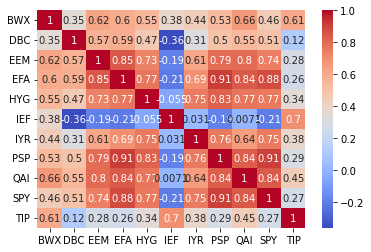

In [58]:
corr = assets.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [167]:
mu_tilde = 0.03
sigma_tilde = 0.07
1-prob([0,1,2,3,4,5], mu_tilde, sigma_tilde)

,Probability
h,
0,0.50000
1,0.66588
2,0.72777
3,0.77105
4,0.80432
5,0.83105
